In [393]:
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

### Завдання 1: Реалізація SVD
-----------------------

In [410]:
def compute_svd(A):
    ATA = np.dot(A.T, A)
    AAT = np.dot(A, A.T)

    eigenvalues_V, V = np.linalg.eigh(ATA)
    eigenvalues_U, U = np.linalg.eigh(AAT)

    sorted_indices_V = np.argsort(eigenvalues_V)[::-1]
    sorted_indices_U = np.argsort(eigenvalues_U)[::-1]

    V = V[:, sorted_indices_V]
    U = U[:, sorted_indices_U]
    eigenvalues_V = eigenvalues_V[sorted_indices_V]

    singular_values = np.sqrt(eigenvalues_V)

    Sigma = np.zeros_like(A, dtype=float)
    np.fill_diagonal(Sigma, singular_values)

    U, _ = np.linalg.qr(U)
    V, _ = np.linalg.qr(V)

    return U, Sigma, V.T


A = np.random.rand(5, 3)
U, Sigma, Vt = compute_svd(A)

reconstructed_A = U.dot(Sigma).dot(Vt)
print("Original Matrix:\n", A)
print("Reconstructed Matrix:\n", reconstructed_A)

Original Matrix:
 [[0.9898091  0.79967595 0.65363106]
 [0.6497079  0.30479701 0.20390293]
 [0.82883704 0.60648058 0.18886546]
 [0.68029282 0.20438725 0.98597693]
 [0.5673286  0.68306726 0.69835535]]
Reconstructed Matrix:
 [[0.9898091  0.79967595 0.65363106]
 [0.6497079  0.30479701 0.20390293]
 [0.82883704 0.60648058 0.18886546]
 [0.68029282 0.20438725 0.98597693]
 [0.5673286  0.68306726 0.69835535]]


### Завдання 2 Частина 1
------------------
#### Зчитування CSV файлу

In [395]:
file_path = 'data/ratings.csv'
df = pd.read_csv(file_path)

ratings_matrix = df.pivot(index='userId', columns='movieId', values='rating')

#### Прибираємо частину данних

In [396]:
ratings_matrix = ratings_matrix.dropna(thresh=50, axis=0)
ratings_matrix = ratings_matrix.dropna(thresh=50, axis=1)

#### Усуваємо особливості оцінювання кожним користувачем 

In [397]:
ratings_matrix_filled = ratings_matrix.fillna(2.5)
R = ratings_matrix_filled.values
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

#### Виконуємо SVD

In [398]:
U, sigma, Vt = svds(R_demeaned, k=min(R.shape)-1)
U

array([[ 0.00336126, -0.03661163,  0.02608473, ...,  0.00426575,
         0.08482072,  0.07541731],
       [-0.02230079,  0.01566151,  0.07439576, ...,  0.03583535,
         0.05064442,  0.02700564],
       [-0.02492984,  0.0778108 , -0.01782421, ..., -0.13481445,
         0.0743632 , -0.00953451],
       ...,
       [ 0.01055423,  0.02836364, -0.04233314, ..., -0.05897128,
         0.07560606,  0.03712138],
       [-0.01124267, -0.00510705, -0.00055124, ...,  0.00921558,
        -0.06837395,  0.0888979 ],
       [ 0.00481379,  0.04640804, -0.00542146, ...,  0.03593854,
        -0.10312075,  0.12527049]])

In [399]:
Vt

array([[-0.03334578, -0.00688231,  0.00567071, ...,  0.01657953,
        -0.0426492 ,  0.02877236],
       [-0.01142045, -0.0084916 , -0.00956849, ..., -0.05176332,
         0.06164407,  0.04328687],
       [-0.00810426,  0.04696931, -0.034232  , ...,  0.03508078,
         0.02179799, -0.11489075],
       ...,
       [-0.10602282, -0.07405219, -0.02056224, ...,  0.02068283,
         0.01003255, -0.01477116],
       [ 0.04832275,  0.00882971,  0.03768684, ..., -0.07961089,
        -0.06938165, -0.0735665 ],
       [ 0.06942976, -0.03298007,  0.02145442, ..., -0.00709507,
        -0.0139024 , -0.0214737 ]])

#### Візуалізуємо матрицю U

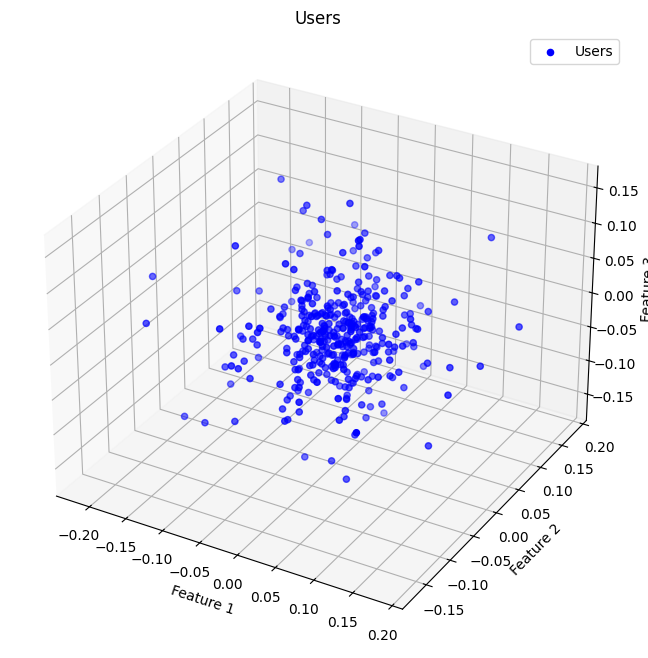

In [400]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(U[:, 0], U[:, 1], U[:, 2], c="b", marker="o", label="Users")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("Users")
ax.legend()
plt.show()

#### Візуалізуємо матрицю V

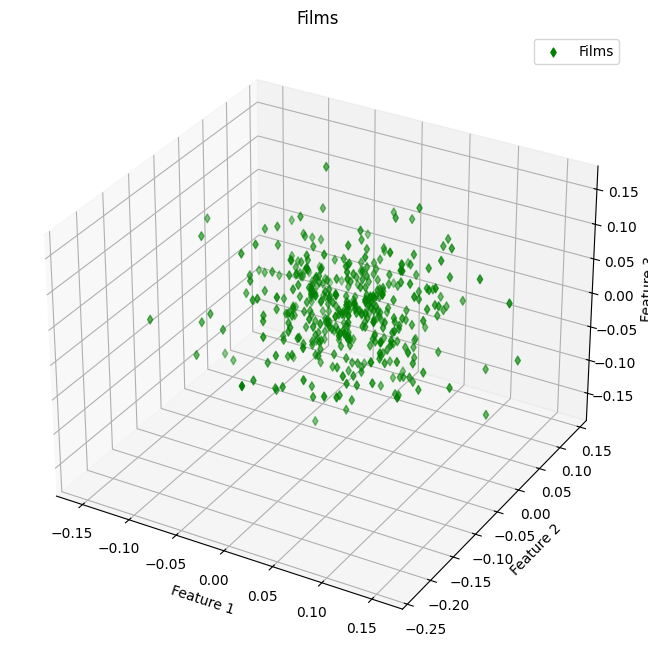

In [401]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Vt[0, :], Vt[1, :], Vt[2, :], c="g", marker="d", label="Films")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("Films")
ax.legend()
plt.show()

### Завдання 2 Частина 2: Алгоритм рекомендацій
----------------------------

#### Матриця із прогнозованими оцінками

In [402]:
sigma_matrix = np.diag(sigma)

all_user_predicted_ratings = np.dot(
    np.dot(U, sigma_matrix), Vt
) + user_ratings_mean.reshape(-1, 1)

preds_df = pd.DataFrame(
    all_user_predicted_ratings,
    columns=ratings_matrix.columns,
    index=ratings_matrix.index,
)

all_user_predicted_ratings, preds_df

(array([[3.99983029, 2.50003881, 4.00031975, ..., 2.50013088, 2.50007873,
         2.49930313],
        [2.49994634, 2.50001227, 2.5001011 , ..., 2.50004138, 2.50002489,
         2.49977967],
        [2.49972981, 4.00006179, 4.00050906, ..., 2.50020838, 2.50012535,
         2.49889052],
        ...,
        [3.99998864, 2.5000026 , 2.5000214 , ..., 2.50000876, 2.50000527,
         2.49995336],
        [2.4999017 , 2.00002248, 2.5001852 , ..., 2.50007581, 2.5000456 ,
         2.49959637],
        [5.00014713, 2.49996635, 4.9997228 , ..., 4.49988653, 3.49993175,
         4.50060415]]),
 movieId    1         2         6         10        11        16        17      \
 userId                                                                          
 1        3.999830  2.500039  4.000320  2.500310  2.499892  2.499722  2.500304   
 4        2.499946  2.500012  2.500101  2.500098  2.499966  2.499912  2.500096   
 6        2.499730  4.000062  4.000509  3.000494  3.999828  3.999557  4.000484   

#### Порівнюємо передбачені рейтинги із актуальними


In [403]:
differences_df = ratings_matrix_filled - preds_df
mean_error = differences_df.abs().mean().mean()

mean_error

0.00036620048731447074

#### Фільтруємо тільки прогнозовані дані

In [404]:
original_non_nan = ratings_matrix.notna()
preds_df_only_predicted = preds_df.where(~original_non_nan)

preds_df_only_predicted, original_non_nan

(movieId    1         2         6         10        11        16        17      \
 userId                                                                          
 1             NaN  2.500039       NaN  2.500310  2.499892  2.499722  2.500304   
 4        2.499946  2.500012  2.500101  2.500098  2.499966  2.499912  2.500096   
 6        2.499730       NaN       NaN       NaN       NaN       NaN       NaN   
 7             NaN  2.499970  2.499749  2.499756  2.500085  2.500219  2.499761   
 10       2.500123  2.499972  2.499768  2.499774  2.500079  2.500202  2.499779   
 ...           ...       ...       ...       ...       ...       ...       ...   
 605           NaN       NaN  2.500000  2.500000  2.500000  2.500000  2.500000   
 606           NaN  2.500002  2.500020  2.500019       NaN  2.499983       NaN   
 607           NaN  2.500003  2.500021  2.500021       NaN  2.499981  2.500020   
 608           NaN       NaN  2.500185       NaN  2.499937       NaN  2.500176   
 610           N

#### Генеруємо рекомендації

In [405]:
def recommend_movies(preds_df, user_id, movies_df, top_n=10):
    user_row = preds_df.loc[user_id].sort_values(ascending=False)

    recommendations = movies_df.loc[user_row.index]
    recommendations["predicted_rating"] = user_row.values

    return recommendations.head(top_n)


movies_df = pd.read_csv("data/movies.csv").set_index("movieId")

recommended_movies_1 = recommend_movies(
    preds_df_only_predicted, user_id=1, movies_df=movies_df
)

recommended_movies_2 = recommend_movies(
    preds_df_only_predicted, user_id=4, movies_df=movies_df
)

recommended_movies_1, recommended_movies_2

(                                                     title  \
 movieId                                                      
 2006                             Mask of Zorro, The (1998)   
 4776                                   Training Day (2001)   
 45722    Pirates of the Caribbean: Dead Man's Chest (2006)   
 8368       Harry Potter and the Prisoner of Azkaban (2004)   
 46578                          Little Miss Sunshine (2006)   
 454                                       Firm, The (1993)   
 35836                       40-Year-Old Virgin, The (2005)   
 2804                             Christmas Story, A (1983)   
 32587                                      Sin City (2005)   
 520                       Robin Hood: Men in Tights (1993)   
 
                                           genres  predicted_rating  
 movieId                                                             
 2006                       Action|Comedy|Romance          2.501661  
 4776                        Cri

### Теоретичні відповіді на ваші запитання:

#### 1. Основні етапи SVD розкладу та його застосування у рекомендаційних системах:

**Основні етапи SVD розкладу:**
- **Розрахунок:** Спочатку розраховуються три матриці `U`, &Sigma;, і `Vt`, де `A = UΣVt`. `U` та `V` містять ортонормовані вектори (ліві та праві сингулярні вектори), а &Sigma; — діагональна матриця з сингулярними значеннями.
- **Зменшення розмірності:** Через вибір параметра `k` можна зменшити розмірність даних, вибираючи `k` найбільших сингулярних значень та відповідні вектори, що призводить до апроксимації початкової матриці.

**Застосування у рекомендаційних системах:**
- **Прогнозування рейтингів:** Використовуючи зменшені матриці `U^k`, &Sigma;^k, і `V^k t`, можна відтворити приблизну матрицю рейтингів, яка використовується для прогнозування невідомих рейтингів.
- **Персоналізація:** За допомогою сингулярних векторів можна ідентифікувати схожі переваги між користувачами або схожі характеристики між об'єктами (наприклад, фільмами), що дозволяє робити персоналізовані рекомендації.

#### 2. Сфери застосування SVD:

SVD широко використовується в різних областях, зокрема:
- **Машинне навчання та штучний інтелект:** для зменшення розмірності даних і покращення алгоритмів навчання.
- **Обробка зображень:** наприклад, для компресії зображень і зниження шуму.
- **Природна мова:** у моделях таких як LSA (Latent Semantic Analysis) для аналізу тексту.
- **Біоінформатика:** для структурного аналізу генетичних і білкових даних.
- **Рекомендаційні системи:** як уже зазначалося, для прогнозування рейтингів.

#### 3. Вплив вибору параметра `k` у SVD розкладі:

- **Якість апроксимації:** Велике `k` покращує точність апроксимації оригінальної матриці, але збільшує обчислювальні витрати.
- **Переоснащення та недооснащення:** Занадто маленьке `k` може не вловити всі важливі особливості даних, що призводить до недооснащення. Занадто велике `k` може призвести до переоснащення, особливо у випадку шумних даних.

#### 4. Переваги та недоліки SVD:

**Переваги:**
- **Міцні математичні основи:** забезпечує оптимальну апроксимацію матриці за даною ранговою обмеженістю.
- **Гнучкість:** можливість використання у широкому діапазоні застосувань.
- **Ефективність у виявленні прихованих факторів:** відмінно підходить для виявлення складних шаблонів.

**Недоліки:**
- **Висока обчислювальна складність:** особливо для великих матриць, що може бути обмежуючим фактором у реальному часі.
- **Чутливість до шуму:** може інтерпретувати шум як значущі фактори, особливо при високому `k`.
- **Необхідність ретельного підходу до передобробки даних:** неправильне оброблення даних може суттєво вплинути на результати SVD.
